In [1]:
#%%
# load package
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import shap
#import shap.explainers.deep.deep_tf
import lime
from lime.lime_image import LimeImageExplainer
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import keras.backend as K
from keras.models import Sequential
import ssl
from skimage.segmentation import mark_boundaries

import argparse
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [20]:
from models.version7.modules.model import A2IModel
from models.version7.modules.lr_scheduler import CustomOneCycleSchedule, LearningRateLogger
import models.version7.functions as functions
from models.version7.cfg_121 import configs

In [3]:
TARGET_COLUMNS = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']
NUM_CLASSES = len(TARGET_COLUMNS)
AUTOTUNE = tf.data.AUTOTUNE
IMAGE_SIZE = [320, 320]
BATCH_SIZE = 1
MODEL_DIR = '/home/n0/a2i006/xai/models/densenet121_1005.h5'
#MODEL_DIR = '/home/n0/a2i006/xai/models/converted_EfficientNetV2B0.tflite'
MODEL_DIR_Q = '/home/n0/a2i006/xai/models/baseline_quant_model.tflite'

DATASET_DIR = '/home/n0/a2i006/xai/dataset'
DATASET_NAME = 'CheXpert-v1.0-small'
TEST_SIZE = 0.1 # enough

In [4]:
# return : dataframe with columns [Path, label_1, label_2, ... label_n]
def csv_to_df(dataset_dir, dataset_name):
    # TODO : load data into pandas dataframe
    data = pd.read_csv(f"{dataset_dir}/valid.csv").fillna(0.0)

    # TODO : fix image path:
    # ex. CheXpert-v1.0/patient0000...
    # ex.       > /mnt/e/dataset/chexpert/CheXpert-v1.0/patient0000...
    data['Path'] = data['Path'].str.replace(dataset_name, dataset_dir, regex=False)

    # TODO : fill null values
    for col_idx in range(5, len(data.columns)):
        data[data.columns[col_idx]] = data[data.columns[col_idx]].astype(str)
        data[data.columns[col_idx]] = data[data.columns[col_idx]].str.replace("-1.0", "0.0").astype(float).fillna(0.0)

    # TODO : column reduction
    target_columns = ['Path'] + TARGET_COLUMNS
    dataframe = data[target_columns].reset_index(drop=True)

    return dataframe

In [5]:
def process_path_validation(image_path, label):
    # Read the image from the path
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=1) #3
    image = tf.image.resize(image, [320, 320])
    image = tf.cast(image, tf.float32) / 255.0

    return image, label

In [6]:
def transform(dataset_dir):
    # make train_images
    train_images = []
    for i in range(64541, 64741):
        img_path = f"{dataset_dir}/valid/patient{i}/study1/view1_frontal.jpg"
        img = image.load_img(img_path, target_size=(320, 320))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = x / 255.0
        train_images.append(x)

    # Convert the list to a numpy array
    # (number_of_images, height, width, channels). (48, 320, 320, 3).
    train_images = np.concatenate(train_images, axis=0) 
    #print(train_images.shape)
    
    return train_images

In [7]:
def auroc(y_true, y_pred):
    return AUC(curve='ROC')(y_true, y_pred)

In [8]:
def get_model_predictions(data):
    model_prediction = model.predict(data)
    print(f"The predicted class is : {decode_predictions(model_prediction, top=1)[0][0][1]}")
    return decode_predictions(model_prediction, top=1)[0][0][1]

In [9]:
def generate_prediction_sample(exp, exp_class, weight = 0.1, show_positive = False, hide_background = False):
    '''
    Method to display and highlight super-pixels used by the black-box model to make predictions
    '''
    image, mask = exp.get_image_and_mask(exp_class, 
                                         positive_only=show_positive, 
                                         num_features=6, 
                                         hide_rest=hide_background,
                                         min_weight=weight
                                        )
    plt.imshow(mark_boundaries(image, mask))
    #plt.savefig('lime_pred.png')
    plt.axis('off')
    plt.show()

In [50]:
def map2layer(x, layer):
    feed_dict = dict(zip([new_model.layers[0].input], [preprocess_input(x.copy())]))
    #feed_dict = dict(zip([interpreter.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(new_model.layers[layer].input, feed_dict)

In [11]:
# GPU Setting
physical_devices = tf.config.list_physical_devices('GPU')
print('Num_GPUs:{}, List:{}'.format(len(physical_devices), physical_devices))

Num_GPUs:1, List:[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [12]:
# load df from csv
df = csv_to_df(DATASET_DIR, DATASET_NAME)

In [13]:
# Filter filenames ending with "_frontal.jpg"
valid_df = df[df['Path'].str.endswith('_frontal.jpg')]
#print(valid_df)

In [74]:
# Dataset for validation
list_ds_valid = tf.data.Dataset.from_tensor_slices((valid_df['Path'].values, valid_df.iloc[:, 1:].values))
#print(list_ds_valid)
ds_valid = list_ds_valid.map(process_path_validation, num_parallel_calls=AUTOTUNE)
#ds_valid = ds_valid.batch(1)
#ds_valid = ds_valid.prefetch(AUTOTUNE)

In [15]:
sample = next(iter(ds_valid))
sample[0][0].shape

TensorShape([320, 320, 1])

Full model

In [21]:
new_model = A2IModel(configs=configs)
new_model.initialize()

In [22]:
new_model.load_weights(filepath = MODEL_DIR)

Quantized model

In [18]:
# load model
#model = load_model(args.model_dir, custom_objects={'CosineDecayWithWarmup': CosineDecayWithWarmup})
#model = load_model(MODEL_DIR, custom_objects={'CosineDecayWithWarmup': CosineDecayWithWarmup, 'AUROC': AUROC})
interpreter = tf.lite.Interpreter(model_path=MODEL_DIR_Q)

In [19]:
interpreter.get_input_details()

[{'name': 'serving_default_input_1:0',
  'index': 0,
  'shape': array([  1, 320, 320,   1], dtype=int32),
  'shape_signature': array([ -1, 320, 320,   1], dtype=int32),
  'dtype': numpy.uint8,
  'quantization': (0.003921568859368563, 0),
  'quantization_parameters': {'scales': array([0.00392157], dtype=float32),
   'zero_points': array([0], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [20]:
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [21]:
input_index = interpreter.get_input_details()[0]['index']
input_index

0

In [22]:
output_index = interpreter.get_output_details()[0]['index']
output_index

776

In [23]:
sum_correct = 0.0
for idx, (x, y) in enumerate(ds_valid):
    img = (x+1.0)/2.0*255.0
    #image = tf.expand_dims(img, axis=0)
    img = tf.cast(img, tf.uint8)
    #print(image)
    #break
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    pred = interpreter.get_tensor(output_index)
    if np.argmax(pred) == np.argmax(y):
        sum_correct += 1.0
    
    #if idx == 2: break

In [24]:
mean_acc = sum_correct/float(idx+1)
mean_acc

0.7376237623762376

In [ ]:
img.shape

Prediction

In [23]:
# Perform inference on the validation dataset
predictions = new_model.predict(ds_valid)

202/202 [==============================] - 5s 16ms/step


In [24]:
predictions[0].shape

(202, 2)

In [25]:
len(predictions)

5

In [27]:
predictions[0]

array([[0.7196131 , 0.2803869 ],
       [0.7295775 , 0.27042252],
       [0.62263036, 0.37736964],
       [0.85813934, 0.14186066],
       [0.5790838 , 0.4209162 ],
       [0.4839072 , 0.51609284],
       [0.74918574, 0.25081426],
       [0.78020185, 0.21979815],
       [0.48803642, 0.51196355],
       [0.8530768 , 0.14692324],
       [0.7963171 , 0.2036829 ],
       [0.8298929 , 0.1701071 ],
       [0.6232012 , 0.37679878],
       [0.81873935, 0.18126062],
       [0.7153501 , 0.2846499 ],
       [0.64397484, 0.35602513],
       [0.64408386, 0.35591614],
       [0.7302238 , 0.26977625],
       [0.9175991 , 0.08240093],
       [0.8095665 , 0.19043349],
       [0.7500427 , 0.24995726],
       [0.7413764 , 0.25862363],
       [0.897189  , 0.10281095],
       [0.6118547 , 0.3881453 ],
       [0.4852732 , 0.5147268 ],
       [0.72722375, 0.27277628],
       [0.66726625, 0.33273372],
       [0.8090872 , 0.19091284],
       [0.8883341 , 0.11166587],
       [0.46437815, 0.5356219 ],
       [0.

In [56]:
predictions[1] # before

array([[0.39659825, 0.30194885, 0.30145285],
       [0.39346722, 0.2989478 , 0.30758494],
       [0.3784169 , 0.30801496, 0.31356817],
       [0.397494  , 0.29770702, 0.30479905],
       [0.40104985, 0.2930189 , 0.3059312 ],
       [0.39052522, 0.29255128, 0.31692347],
       [0.39240327, 0.2971999 , 0.31039685],
       [0.39295828, 0.29387936, 0.3131624 ],
       [0.40001267, 0.29231468, 0.3076727 ],
       [0.40341905, 0.29661423, 0.2999667 ],
       [0.39252895, 0.29993358, 0.30753753],
       [0.39256233, 0.30012885, 0.30730876],
       [0.40448493, 0.28938565, 0.30612943],
       [0.38956448, 0.30125496, 0.3091806 ],
       [0.39740282, 0.29592153, 0.30667567],
       [0.39469674, 0.2976855 , 0.30761775],
       [0.3969607 , 0.29182664, 0.31121263],
       [0.39555368, 0.29493964, 0.30950674],
       [0.39066678, 0.303739  , 0.30559418],
       [0.38988423, 0.3013314 , 0.30878437],
       [0.4103798 , 0.28917217, 0.3004481 ],
       [0.3873525 , 0.30241266, 0.3102348 ],
       [0.

In [28]:
predictions[1]

array([[0.81658715, 0.10439733, 0.07901556],
       [0.8940604 , 0.05149392, 0.05444566],
       [0.76854765, 0.16212232, 0.06933001],
       [0.9203828 , 0.03531387, 0.0443033 ],
       [0.90790623, 0.05032495, 0.04176876],
       [0.8718744 , 0.07071456, 0.05741104],
       [0.91088593, 0.04213786, 0.04697618],
       [0.92125946, 0.03637126, 0.04236921],
       [0.78620386, 0.1416454 , 0.07215069],
       [0.76779974, 0.14533718, 0.08686305],
       [0.9284504 , 0.02956495, 0.04198465],
       [0.89530754, 0.05325717, 0.05143536],
       [0.75808954, 0.1749474 , 0.06696305],
       [0.8297307 , 0.09969899, 0.07057039],
       [0.89772874, 0.05178443, 0.05048682],
       [0.9012846 , 0.05573751, 0.04297784],
       [0.8824604 , 0.06289881, 0.05464069],
       [0.91976994, 0.03643029, 0.04379987],
       [0.8470691 , 0.09201795, 0.06091297],
       [0.87269646, 0.06562667, 0.06167693],
       [0.8608109 , 0.07500272, 0.06418643],
       [0.9022233 , 0.04401694, 0.05375971],
       [0.

In [29]:
atel_labels = (np.argmax(predictions[0], axis=1)).astype(int)
atel_labels

array([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1])

In [30]:
card_labels = (np.argmax(predictions[1], axis=1)).astype(int)
card_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

In [31]:
cons_labels = (np.argmax(predictions[2], axis=1)).astype(int)
cons_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

In [32]:
edem_labels = (np.argmax(predictions[3], axis=1)).astype(int)
edem_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

In [33]:
plef_labels = (np.argmax(predictions[4], axis=1)).astype(int)
plef_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1])

In [34]:
# 각 label==1일 확률
probs = []
for label_arr in predictions:
    label_prob = []
    for pred in label_arr:
        prob = pred[1]
        label_prob.append(prob)
    probs.append(label_prob)
predictions2 = np.empty((202,5))
for i in range(len(probs[0])):
    row = [elem[i] for elem in probs]
    predictions2[i] = row

In [67]:
predictions2.shape

(202, 5)

In [35]:
predictions2[0]

array([0.28038689, 0.10439733, 0.04914454, 0.10830957, 0.04182669])

In [37]:
# Get the true labels from the validation dataset
true_labels = np.array([label.numpy() for _, label in ds_valid])
true_labels = np.reshape(true_labels, (-1, NUM_CLASSES))  # Reshape to 2D array

In [38]:
images = transform(DATASET_DIR)

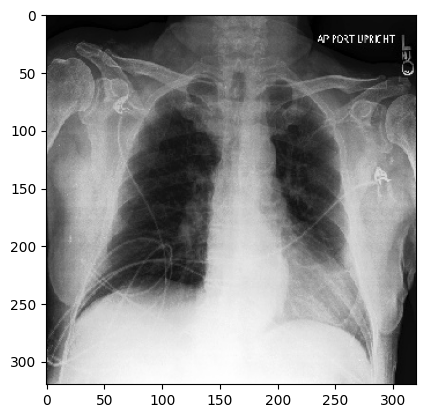

In [39]:
plt.imshow(images[0])

In [40]:
explainer = LimeImageExplainer()
explainer_l = explainer.explain_instance(images[0], new_model.predict, hide_color=0, top_labels=2, num_samples=1000)
#explainer_l = explainer.explain_instance(images[0], interpreter.get_tensor, hide_color=0, top_labels=2, num_samples=1000)

plt.imshow(explainer_l.segments)
#plt.savefig('lime.png')

  1%|          | 9/1000 [00:00<00:27, 35.92it/s]


ValueError: in user code:

    File "/home/n0/a2i006/anaconda3/envs/env/lib/python3.10/site-packages/keras/engine/training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "/home/n0/a2i006/anaconda3/envs/env/lib/python3.10/site-packages/keras/engine/training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/n0/a2i006/anaconda3/envs/env/lib/python3.10/site-packages/keras/engine/training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "/home/n0/a2i006/anaconda3/envs/env/lib/python3.10/site-packages/keras/engine/training.py", line 2111, in predict_step
        return self(x, training=False)
    File "/home/n0/a2i006/anaconda3/envs/env/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/tmp/__autograph_generated_file_crihms5.py", line 12, in tf__call
        feature = ag__.converted_call(ag__.ld(self).extract_feature, (ag__.ld(x),), dict(training=ag__.ld(training)), fscope)
    File "/tmp/__autograph_generated_file6w74my51.py", line 86, in tf__extract_feature
        ag__.for_stmt(ag__.converted_call(ag__.ld(enumerate), (ag__.ld(self).feature_extractor,), None, fscope), None, loop_body_1, get_state_4, set_state_4, ('feature', 'feature_for_skip'), {'iterate_names': '(idx, layer_name)'})
    File "/tmp/__autograph_generated_file6w74my51.py", line 84, in loop_body_1
        ag__.if_stmt(('densenet_denseblock' in ag__.ld(layer_name)) & ('bn1' in ag__.ld(layer_name)), if_body_2, else_body_2, get_state_3, set_state_3, ('feature', 'feature_for_skip'), 2)
    File "/tmp/__autograph_generated_file6w74my51.py", line 83, in else_body_2
        ag__.if_stmt(('densenet_denseblock' in ag__.ld(layer_name)) & ('concatenate' in ag__.ld(layer_name)), if_body_1, else_body_1, get_state_2, set_state_2, ('feature', 'feature_for_skip'), 2)
    File "/tmp/__autograph_generated_file6w74my51.py", line 82, in else_body_1
        feature = ag__.converted_call(ag__.converted_call(ag__.ld(getattr), (ag__.ld(self), ag__.ld(layer_name)), None, fscope), (ag__.ld(feature),), dict(training=ag__.ld(training)), fscope)

    ValueError: Exception encountered when calling layer 'a2i_model_1' (type A2IModel).
    
    in user code:
    
        File "/home/n0/a2i006/xai/models/version7/modules/model.py", line 171, in call  *
            feature = self.extract_feature(x, training=training)
        File "/home/n0/a2i006/xai/models/version7/modules/model.py", line 151, in extract_feature  *
            feature = getattr(self, layer_name)(feature, training=training)
        File "/home/n0/a2i006/anaconda3/envs/env/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "/home/n0/a2i006/anaconda3/envs/env/lib/python3.10/site-packages/keras/engine/input_spec.py", line 280, in assert_input_compatibility
            raise ValueError(
    
        ValueError: Input 0 of layer "densenet_stem_conv" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (None, 326, 326, 3)
    
    
    Call arguments received by layer 'a2i_model_1' (type A2IModel):
      • X=tf.Tensor(shape=(None, 320, 320, 3), dtype=float32)
      • training=False


In [61]:
temp, mask = explainer.get_image_and_mask(240, positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

AttributeError: 'LimeImageExplainer' object has no attribute 'get_image_and_mask'

In [62]:
#generate_prediction_sample(exp, exp.top_labels[0], show_positive = True, hide_background = True)
generate_prediction_sample(explainer_l, explainer_l.top_labels[1], show_positive = False, hide_background = False)    

NameError: name 'explainer_l' is not defined

In [41]:
# Initialize a list to store dataset elements
elements = []

# Iterate over the dataset and collect elements
for element in ds_valid:
    resized_image = tf.image.resize(element[0].numpy(), IMAGE_SIZE)
    print(element[1])
    elements.append(resized_image.numpy())

# Convert the elements list to a NumPy array
elements = np.array(elements)
# Reshape the elements array
X = np.squeeze(elements, axis=1)

tf.Tensor([[0. 1. 0. 0. 0.]], shape=(1, 5), dtype=float64)
tf.Tensor([[0. 0. 0. 0. 0.]], shape=(1, 5), dtype=float64)
tf.Tensor([[0. 0. 0. 1. 0.]], shape=(1, 5), dtype=float64)
tf.Tensor([[0. 0. 0. 0. 0.]], shape=(1, 5), dtype=float64)
tf.Tensor([[1. 0. 0. 0. 1.]], shape=(1, 5), dtype=float64)
tf.Tensor([[1. 1. 0. 0. 0.]], shape=(1, 5), dtype=float64)
tf.Tensor([[0. 0. 0. 0. 0.]], shape=(1, 5), dtype=float64)
tf.Tensor([[0. 0. 0. 0. 0.]], shape=(1, 5), dtype=float64)
tf.Tensor([[1. 1. 1. 0. 1.]], shape=(1, 5), dtype=float64)
tf.Tensor([[0. 1. 0. 0. 0.]], shape=(1, 5), dtype=float64)
tf.Tensor([[0. 0. 0. 0. 0.]], shape=(1, 5), dtype=float64)
tf.Tensor([[0. 0. 0. 0. 0.]], shape=(1, 5), dtype=float64)
tf.Tensor([[1. 1. 1. 1. 1.]], shape=(1, 5), dtype=float64)
tf.Tensor([[0. 1. 0. 0. 0.]], shape=(1, 5), dtype=float64)
tf.Tensor([[0. 0. 0. 0. 0.]], shape=(1, 5), dtype=float64)
tf.Tensor([[1. 0. 1. 1. 0.]], shape=(1, 5), dtype=float64)
tf.Tensor([[0. 0. 0. 0. 0.]], shape=(1, 5), dtype=float6

In [92]:
# define a masker that is used to mask out partitions of the input image, this one uses a blurred background
masker0 = shap.maskers.Image("inpaint_telea", X[0].shape)    

In [73]:
X[201].shape

(320, 320, 1)

In [43]:
def f(X):
    tmp = X.copy()    
    tmp = tmp / 255.0
    return new_model(tmp)[0]

In [44]:
def f1(X):
    tmp = X.copy()    
    tmp = tmp / 255.0
    return new_model(tmp)[1]

Deep explainer

In [101]:
# select backgroud for shap
#background = images[np.random.choice(images.shape[0], 100, replace=False)]
# DeepExplainer to explain predictions of the model
explainer_sd = shap.DeepExplainer(new_model, X[0][:10])
shap_values = explainer_sd(X[:10])

InvalidArgumentError: {{function_node __wrapped__Pack_N_5_device_/job:localhost/replica:0/task:0/device:GPU:0}} Shapes of all inputs must match: values[0].shape = [1,2] != values[1].shape = [1,3] [Op:Pack] name: packed

Vanilla explainer

In [47]:
explainer_s = shap.Explainer(f, masker0, output_names=TARGET_COLUMNS)
# compute shap values
#shap_values = explainer_s.shap_values(images[0])
shap_values = explainer_s(X[:10], max_evals = 100, batch_size=BATCH_SIZE, outputs=shap.Explanation.argsort.flip[:1])

 88%|████████▊ | 86/98 [00:02<00:00, 24.37it/s] 
100it [00:04, 18.81it/s]                       
 98%|█████████▊| 96/98 [00:04<00:00, 17.93it/s]
Partition explainer: 11it [01:39,  9.91s/it]                        


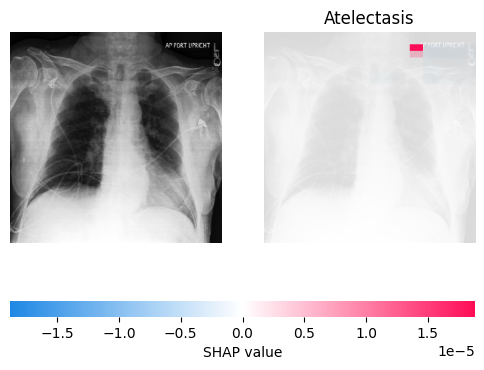

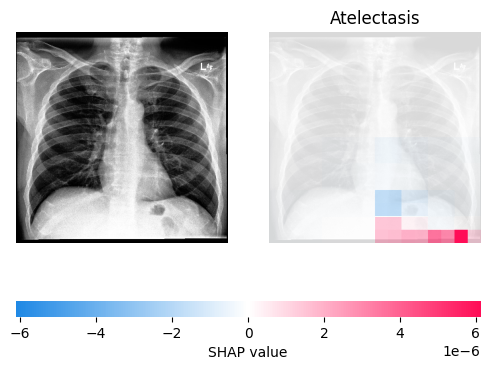

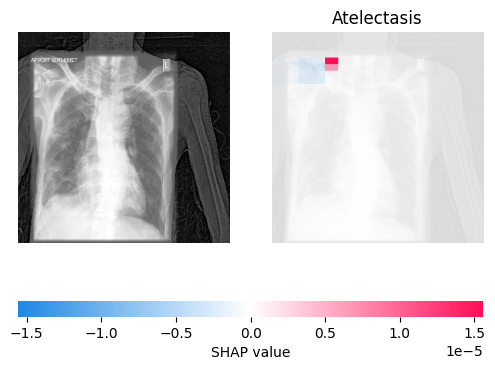

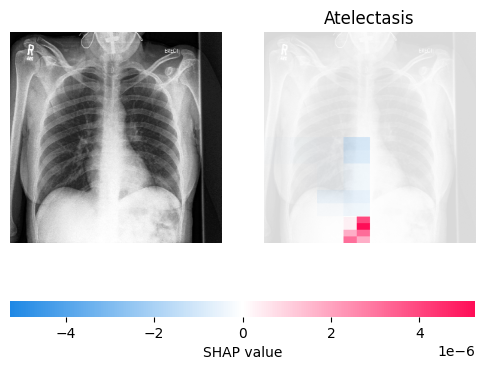

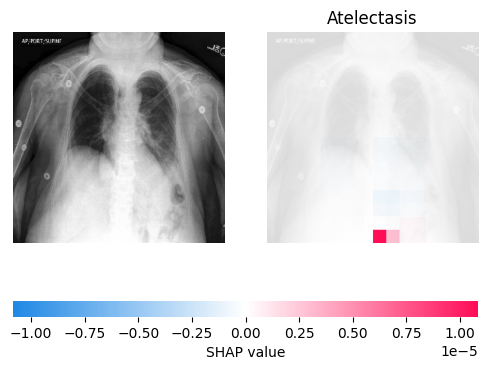

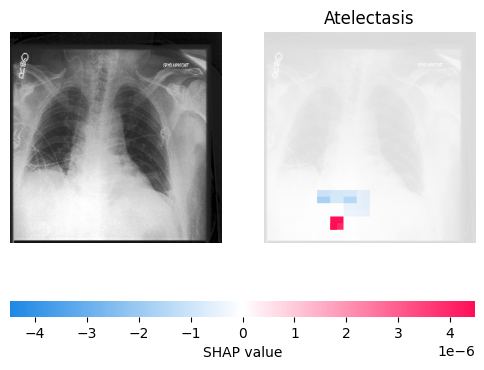

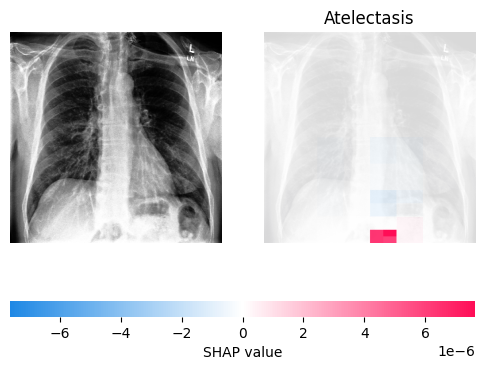

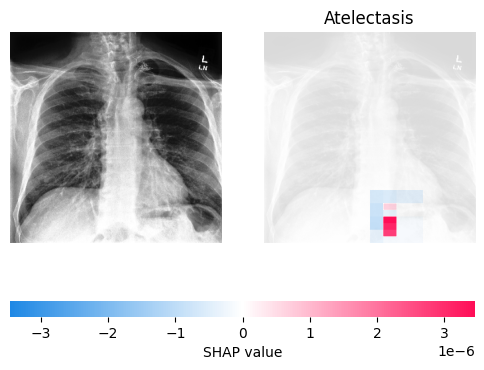

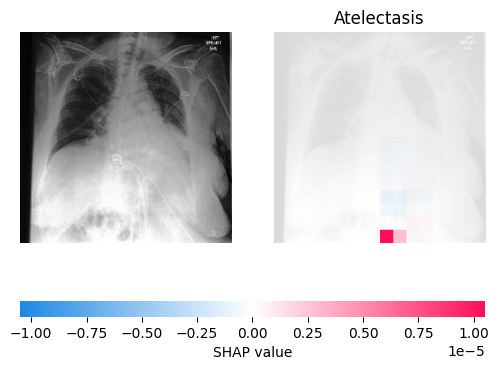

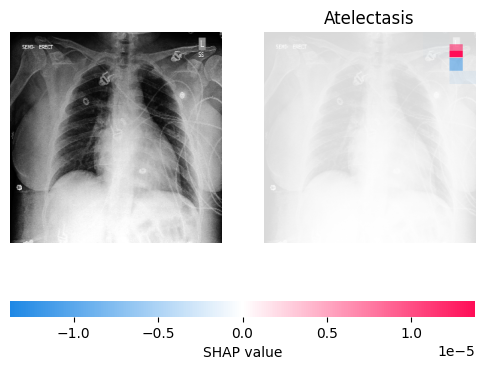

In [44]:
for i in range(10):
    shap.image_plot(shap_values[i])

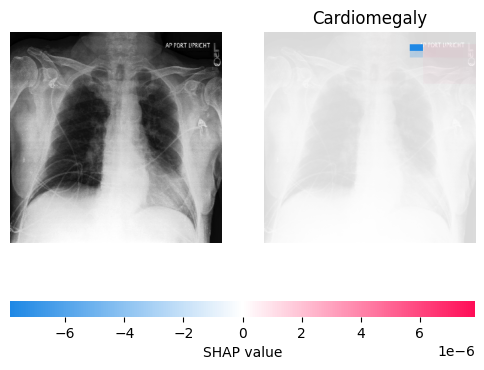

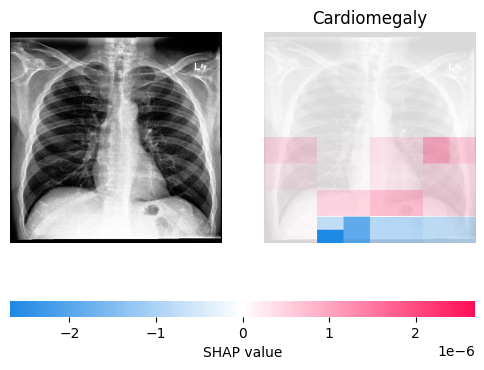

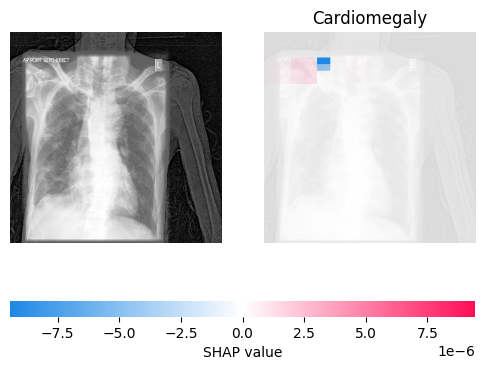

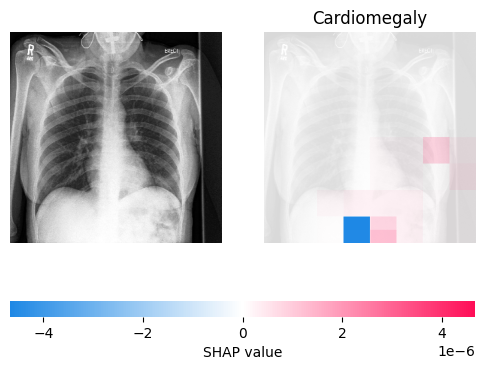

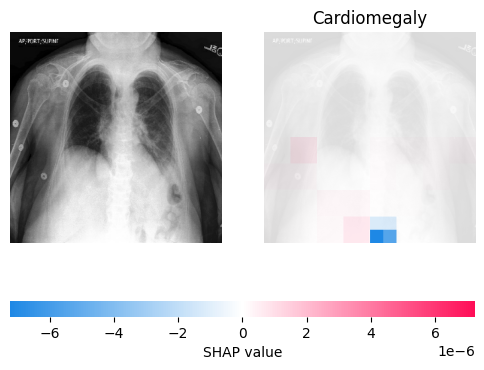

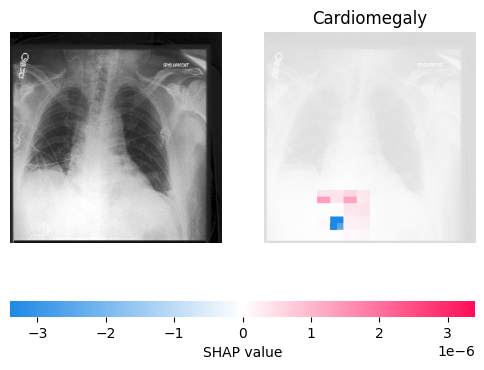

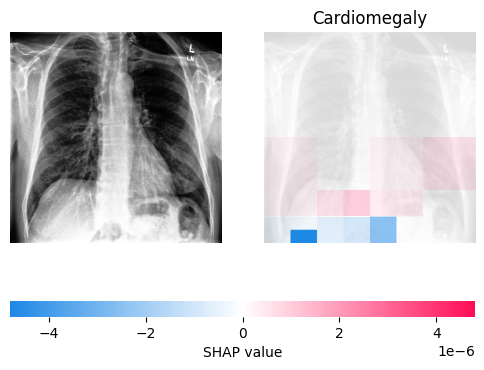

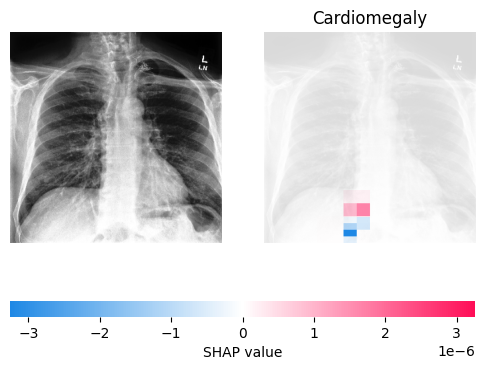

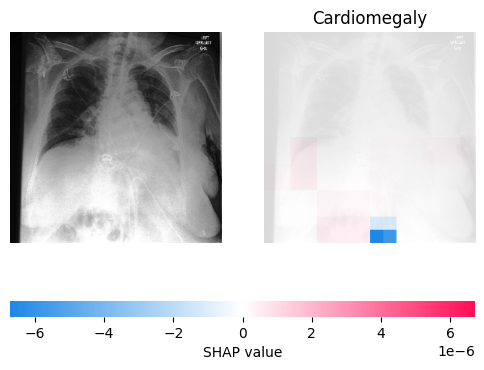

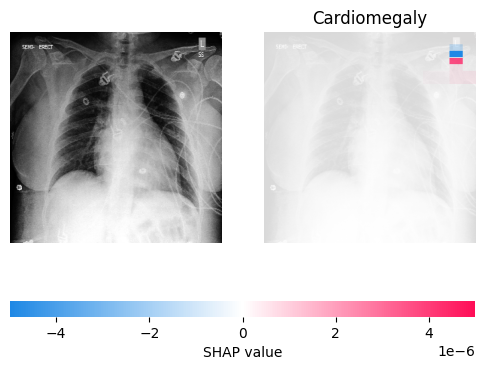

In [48]:
for i in range(10):
    shap.image_plot(shap_values[i])

In [46]:
# select backgroud for shap
#background = images[np.random.choice(images.shape[0], 1, replace=False)]
# DeepExplainer to explain predictions of the model
explainer_s = shap.Explainer(f1, masker, output_names=TARGET_COLUMNS)
#explainer_sd = shap.DeepExplainer(f, masker)
# compute shap values
#shap_values = explainer_s.shap_values(images[0])
shap_values = explainer_s(X[:10], max_evals = 100, batch_size=BATCH_SIZE, outputs=shap.Explanation.argsort.flip[:1])

100%|██████████| 98/98 [00:08<00:00,  7.26it/s]
100it [00:08,  7.16it/s]                       
100%|██████████| 98/98 [00:08<00:00,  7.18it/s]
100it [00:08,  7.18it/s]                       
100%|██████████| 98/98 [00:07<00:00,  7.49it/s]
100it [00:08,  7.45it/s]                       
100%|██████████| 98/98 [00:07<00:00,  7.88it/s]
100it [00:07,  7.74it/s]                       
100%|██████████| 98/98 [00:08<00:00,  7.29it/s]
100it [00:08,  7.23it/s]                       
100%|██████████| 98/98 [00:07<00:00,  7.84it/s]
100it [00:07,  7.63it/s]                       
100%|██████████| 98/98 [00:08<00:00,  7.27it/s]
100it [00:08,  7.22it/s]                       
100%|██████████| 98/98 [00:07<00:00,  8.00it/s]
100it [00:07,  7.76it/s]                       
100%|██████████| 98/98 [00:08<00:00,  6.85it/s]
100it [00:08,  6.92it/s]                       
Partition explainer: 11it [02:16, 13.70s/it]                        


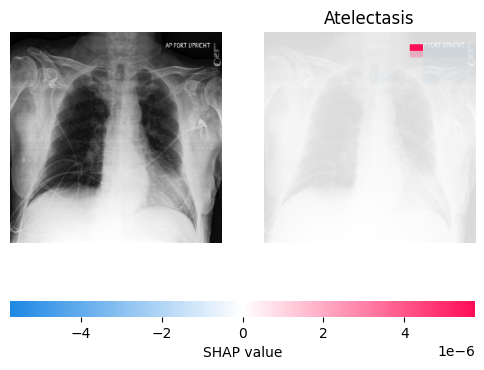

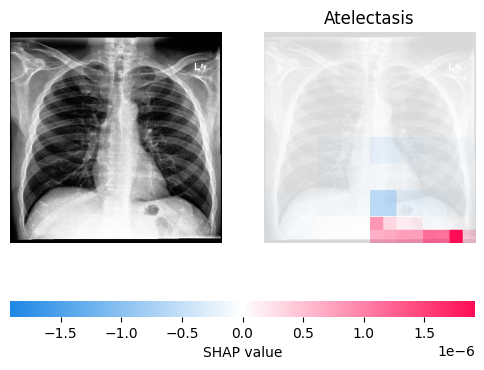

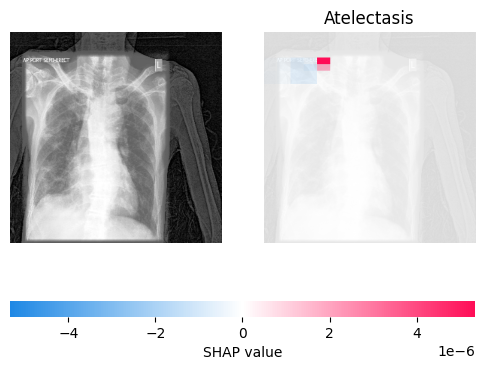

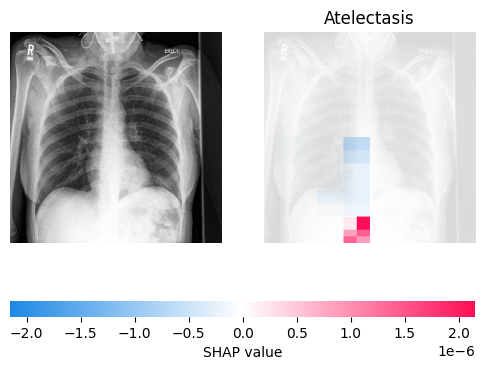

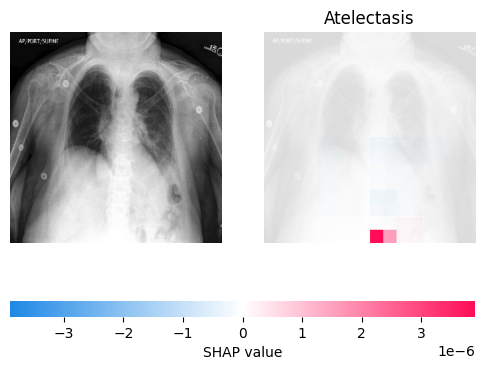

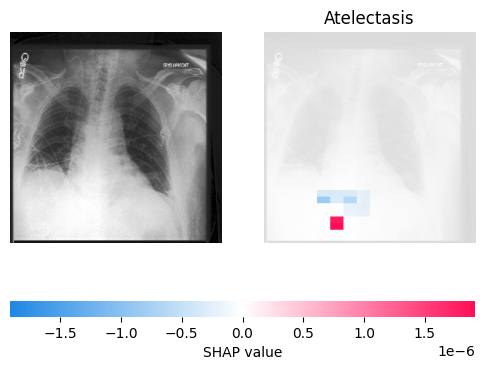

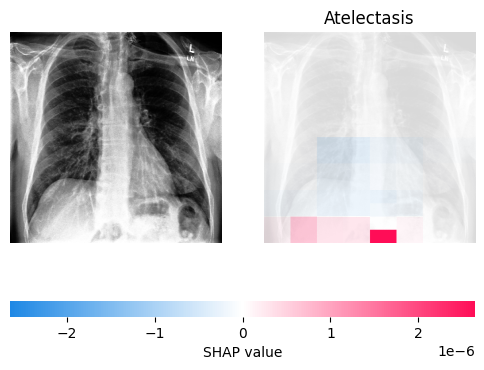

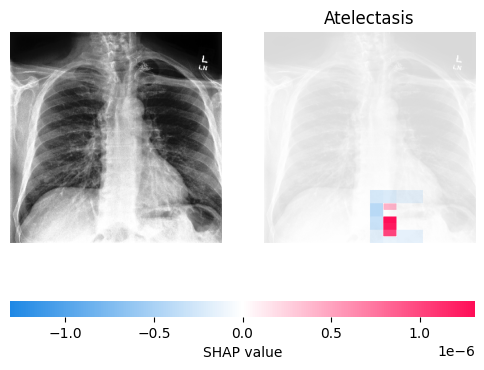

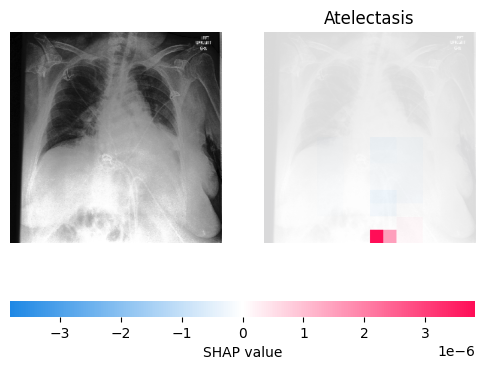

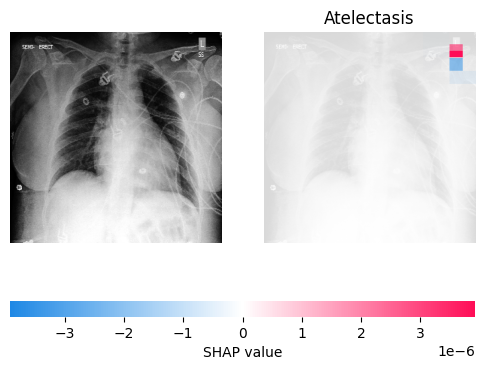

In [54]:
for i in range(10):
    shap.image_plot(shap_values[i])

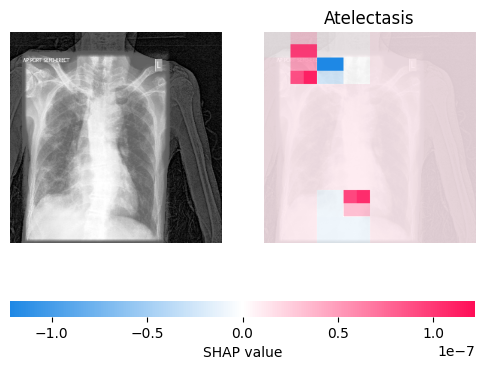

In [68]:
shap.image_plot(shap_values[1])

In [46]:
print(shap_values[0][0])

.values =
array([[[-1.31601701e-08]],

       [[-1.31601701e-08]],

       [[-1.31601701e-08]],

       [[-1.31601701e-08]],

       [[-1.31601701e-08]],

       [[-1.31601701e-08]],

       [[-1.31601701e-08]],

       [[-1.31601701e-08]],

       [[-1.31601701e-08]],

       [[-1.31601701e-08]],

       [[-1.31601701e-08]],

       [[-1.31601701e-08]],

       [[-1.31601701e-08]],

       [[-1.31601701e-08]],

       [[-1.31601701e-08]],

       [[-1.31601701e-08]],

       [[-1.31601701e-08]],

       [[-1.31601701e-08]],

       [[-1.31601701e-08]],

       [[-1.31601701e-08]],

       [[-1.31601701e-08]],

       [[-1.31601701e-08]],

       [[-1.31601701e-08]],

       [[-1.31601701e-08]],

       [[-1.31601701e-08]],

       [[-1.31601701e-08]],

       [[-1.31601701e-08]],

       [[-1.31601701e-08]],

       [[-1.31601701e-08]],

       [[-1.31601701e-08]],

       [[-1.31601701e-08]],

       [[-1.31601701e-08]],

       [[-1.31601701e-08]],

       [[-1.31601701e-08]],

    

In [ ]:
# multi-label